<a href="https://colab.research.google.com/github/AashiDutt/Datacamp-Articles-Code/blob/main/Fine_tune_SAM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Step 1: Install SAM-2

In [ ]:
!git clone https://github.com/facebookresearch/segment-anything-2
%cd /content/segment-anything-2
!pip install -q -e .

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 510, done.
remote: Total 510 (delta 0), reused 0 (delta 0), pack-reused 510 (from 1)
Receiving objects: 100% (510/510), 88.46 MiB | 22.12 MiB/s, done.
Resolving deltas: 100% (157/157), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.3 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done


#### Step 2: Download dataset

In [ ]:
# get dataset from Kaggle
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anujd9","key":"47e7711c52b5b19e2a05411f57efad10"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d polomarco/chest-ct-segmentation


Dataset URL: https://www.kaggle.com/datasets/polomarco/chest-ct-segmentation
License(s): unknown
100% 1.60G/1.61G [00:51<00:00, 34.6MB/s]
100% 1.61G/1.61G [00:51<00:00, 33.7MB/s]


In [ ]:
!unzip chest-ct-segmentation.zip -d chest-ct-segmentation



Streaming output truncated to the last 5000 lines.
  inflating: chest-ct-segmentation/masks/masks/ID00290637202279304677843_mask_155.jpg  
  inflating: chest-ct-segmentation/masks/masks/ID00290637202279304677843_mask_156.jpg  
  inflating: chest-ct-segmentation/masks/masks/ID00290637202279304677843_mask_157.jpg  
  inflating: chest-ct-segmentation/masks/masks/ID00290637202279304677843_mask_158.jpg  
  inflating: chest-ct-segmentation/masks/masks/ID00290637202279304677843_mask_159.jpg  
  inflating: chest-ct-segmentation/masks/masks/ID00290637202279304677843_mask_16.jpg  
  inflating: chest-ct-segmentation/masks/masks/ID00290637202279304677843_mask_160.jpg  
  inflating: chest-ct-segmentation/masks/masks/ID00290637202279304677843_mask_161.jpg  
  inflating: chest-ct-segmentation/masks/masks/ID00290637202279304677843_mask_162.jpg  
  inflating: chest-ct-segmentation/masks/masks/ID00290637202279304677843_mask_163.jpg  
  inflating: chest-ct-segmentation/masks/masks/ID002906372022793046778

In [ ]:
!ls chest-ct-segmentation


images	masks  pretrained_model  train.csv


#### Step 3: Download SAM-2 checkpoints

In [ ]:
!wget -O sam2_hiera_tiny.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt"
!wget -O sam2_hiera_small.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt"
!wget -O sam2_hiera_base_plus.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt"
!wget -O sam2_hiera_large.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt"

--2024-09-01 03:56:10--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.239.50.104, 18.239.50.18, 18.239.50.120, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.239.50.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155906050 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2_hiera_tiny.pt’

sam2_hiera_tiny.pt  100%[===================>] 148.68M   331MB/s    in 0.4s    

2024-09-01 03:56:11 (331 MB/s) - ‘sam2_hiera_tiny.pt’ saved [155906050/155906050]

--2024-09-01 03:56:11--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.239.50.104, 18.239.50.18, 18.239.50.120, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.239.50.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184309650 (176M) [applicatio

#### Step 3: Prepare Data

In [ ]:
%cd /content/segment-anything-2

/content/segment-anything-2


In [ ]:
import numpy as np
import torch
import cv2
import os
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [ ]:
# torch random seed
import torch
import random

def seedEverything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seedEverything()

In [ ]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Path to the chest-ct-segmentation dataset folder
data_dir = "/content/segment-anything-2/chest-ct-segmentation"
images_dir = os.path.join(data_dir, "images/images")
masks_dir = os.path.join(data_dir, "masks/masks")

# Load the train.csv file
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))

# Split the data into two halves: one for training and one for testing
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Prepare the training data list
train_data = []
for index, row in train_df.iterrows():
    image_name = row['ImageId']
    mask_name = row['MaskId']

    # Append image and corresponding mask paths
    train_data.append({
        "image": os.path.join(images_dir, image_name),
        "annotation": os.path.join(masks_dir, mask_name)
    })

# Prepare the testing data list (if needed for inference or evaluation later)
test_data = []
for index, row in test_df.iterrows():
    image_name = row['ImageId']
    mask_name = row['MaskId']

    # Append image and corresponding mask paths
    test_data.append({
        "image": os.path.join(images_dir, image_name),
        "annotation": os.path.join(masks_dir, mask_name)
    })

# Now you can use train_data for training and test_data for testing/inferencing


In [ ]:
len(train_data)

13366

In [ ]:
train_data[0]

{'image': '/content/segment-anything-2/chest-ct-segmentation/images/images/ID00381637202299644114027_20.jpg',
 'annotation': '/content/segment-anything-2/chest-ct-segmentation/masks/masks/ID00381637202299644114027_mask_20.jpg'}

In [ ]:
# # WORKING CODE - 1
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors


# def read_batch(data, visualize_data=False):
#     # Select a random entry
#     ent = data[np.random.randint(len(data))]

#     # Get full paths
#     Img = cv2.imread(ent["image"])[..., ::-1]  # Convert BGR to RGB
#     ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)  # Read annotation as grayscale

#     if Img is None or ann_map is None:
#         print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
#         return None, None, None, 0

#     # Resize image and mask
#     r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])  # Scaling factor
#     Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
#     ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

#     # Initialize a single binary mask
#     binary_mask = np.zeros_like(ann_map, dtype=np.uint8)
#     points = []

#     # Get binary masks and combine them into a single mask
#     inds = np.unique(ann_map)[1:]  # Skip the background (index 0)
#     for ind in inds:
#         mask = (ann_map == ind).astype(np.uint8)  # Create binary mask for each unique index
#         binary_mask = np.maximum(binary_mask, mask)  # Combine with the existing binary mask

#     # Erode the combined binary mask to avoid boundary points
#     eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

#     # Get all coordinates inside the eroded mask and choose a random point
#     coords = np.argwhere(eroded_mask > 0)
#     if len(coords) > 0:
#         for _ in inds:  # Select as many points as there are unique labels
#             yx = np.array(coords[np.random.randint(len(coords))])
#             points.append([yx[1], yx[0]])

#     points = np.array(points)

#     # Add channel dimension to the binary mask
#     binary_mask = np.expand_dims(binary_mask, axis=-1)  # Now shape is (1024, 1024, 1)
#     binary_mask = binary_mask.transpose((2, 0, 1))  # Now shape is (1, 1024, 1024
#     points = np.expand_dims(points, axis=1)  # Now shape is (1024, 1024, 1)

#     # Return the image, binarized mask, points, and number of masks
#     return Img, binary_mask, points, len(inds)


# # Visualize the data
# Img1, masks1, points1, num_masks = read_batch(train_data, visualize_data=True)

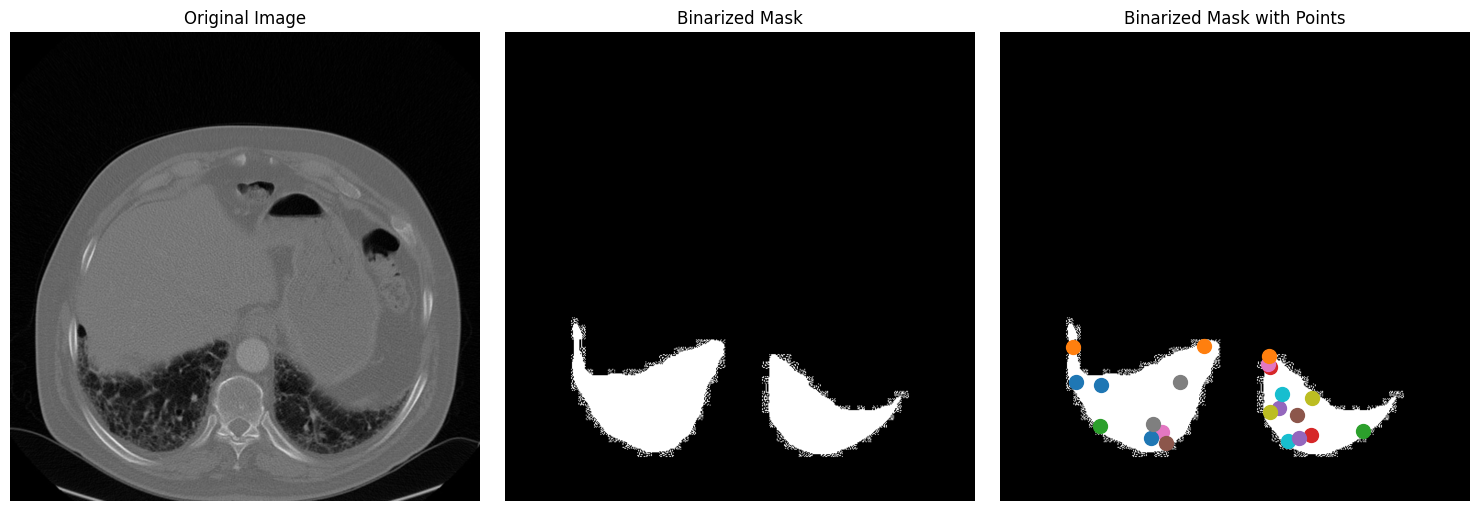

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def read_batch(data, visualize_data=False):
    # Select a random entry
    ent = data[np.random.randint(len(data))]

    # Get full paths
    Img = cv2.imread(ent["image"])[..., ::-1]  # Convert BGR to RGB
    ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)  # Read annotation as grayscale

    if Img is None or ann_map is None:
        print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
        return None, None, None, 0

    # Resize image and mask
    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])  # Scaling factor
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

    # Initialize a single binary mask
    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)
    points = []

    # Get binary masks and combine them into a single mask
    inds = np.unique(ann_map)[1:]  # Skip the background (index 0)
    for ind in inds:
        mask = (ann_map == ind).astype(np.uint8)  # Create binary mask for each unique index
        binary_mask = np.maximum(binary_mask, mask)  # Combine with the existing binary mask

    # Erode the combined binary mask to avoid boundary points
    eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

    # Get all coordinates inside the eroded mask and choose a random point
    coords = np.argwhere(eroded_mask > 0)
    if len(coords) > 0:
        for _ in inds:  # Select as many points as there are unique labels
            yx = np.array(coords[np.random.randint(len(coords))])
            points.append([yx[1], yx[0]])

    points = np.array(points)

    if visualize_data:
        # Plotting the images and points
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(Img)
        plt.axis('off')

        # Segmentation Mask (binary_mask)
        plt.subplot(1, 3, 2)
        plt.title('Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')

        # Mask with Points in Different Colors
        plt.subplot(1, 3, 3)
        plt.title('Binarized Mask with Points')
        plt.imshow(binary_mask, cmap='gray')

        # Plot points in different colors
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100, label=f'Point {i+1}')  # Corrected to plot y, x order

        # plt.legend()
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    binary_mask = np.expand_dims(binary_mask, axis=-1)  # Now shape is (1024, 1024, 1)
    binary_mask = binary_mask.transpose((2, 0, 1))
    points = np.expand_dims(points, axis=1)

    # Return the image, binarized mask, points, and number of masks
    return Img, binary_mask, points, len(inds)

# Visualize the data
Img1, masks1, points1, num_masks = read_batch(train_data, visualize_data=True)

In [ ]:
print(Img1.shape)
print(masks1.shape)
print(points1.shape)
print(num_masks)

(1024, 1024, 3)
(1, 1024, 1024)
(22, 1, 2)
22


## Step 4: Fine-tuning SAM-2

#### Load model checkpoints

In [ ]:
sam2_checkpoint = "sam2_hiera_small.pt"  # @param ["sam2_hiera_tiny.pt", "sam2_hiera_small.pt", "sam2_hiera_base_plus.pt", "sam2_hiera_large.pt"]
model_cfg = "sam2_hiera_s.yaml" # @param ["sam2_hiera_t.yaml", "sam2_hiera_s.yaml", "sam2_hiera_b+.yaml", "sam2_hiera_l.yaml"]

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

#### Configure hyperparameters

In [ ]:
# Train mask decoder.
predictor.model.sam_mask_decoder.train(True)

# Train prompt encoder.
predictor.model.sam_prompt_encoder.train(True)

# Configure optimizer.
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=0.0001,weight_decay=1e-4) #1e-5, weight_decay = 4e-5

# Mix precision.
scaler = torch.cuda.amp.GradScaler()

# No. of steps to train the model.
NO_OF_STEPS = 3000 # @param 2000 try 100000

# Fine-tuned model name.
FINE_TUNED_MODEL_NAME = "fine_tuned_sam2"

#### Start training

In [ ]:
import torch
import torch.nn.utils

# Initialize scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2) # 500 , 250, gamma = 0.1
accumulation_steps = 4  # Number of steps to accumulate gradients before updating

for step in range(1, NO_OF_STEPS + 1):
    with torch.cuda.amp.autocast():
        image, mask, input_point, num_masks = read_batch(train_data, visualize_data=False)
        if image is None or mask is None or num_masks == 0:
            continue

        input_label = np.ones((num_masks, 1))
        if not isinstance(input_point, np.ndarray) or not isinstance(input_label, np.ndarray):
            continue

        if input_point.size == 0 or input_label.size == 0:
            continue

        predictor.set_image(image)
        mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
        if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0 or labels.shape[0] == 0:
            continue

        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
            points=(unnorm_coords, labels), boxes=None, masks=None,
        )

        batched_mode = unnorm_coords.shape[0] > 1
        high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
        low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
            image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=True,
            repeat_image=batched_mode,
            high_res_features=high_res_features,
        )
        prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

        gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
        prd_mask = torch.sigmoid(prd_masks[:, 0])
        seg_loss = (-gt_mask * torch.log(prd_mask + 0.000001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean()

        inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
        iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
        score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
        loss = seg_loss + score_loss * 0.05

        # Apply gradient accumulation
        loss = loss / accumulation_steps
        scaler.scale(loss).backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)

        if step % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            predictor.model.zero_grad()

        # Update scheduler
        scheduler.step()

        if step % 500 == 0:
            FINE_TUNED_MODEL = FINE_TUNED_MODEL_NAME + "_" + str(step) + ".torch"
            torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)

        if step == 1:
            mean_iou = 0

        mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())

        if step % 100 == 0:
            print("Step " + str(step) + ":\t", "Accuracy (IoU) = ", mean_iou)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Step 100:	 Accuracy (IoU) =  0.3742327513762748
Step 200:	 Accuracy (IoU) =  0.5224678655860632
Step 300:	 Accuracy (IoU) =  0.6130454602623383
Step 400:	 Accuracy (IoU) =  0.6663274942292488
Step 500:	 Accuracy (IoU) =  0.6829292557877855
Step 700:	 Accuracy (IoU) =  0.698009019950944
Step 800:	 Accuracy (IoU) =  0.7276738222682939
Step 900:	 Accuracy (IoU) =  0.6943812255788345
Step 1000:	 Accuracy (IoU) =  0.7231011046385154
Step 1100:	 Accuracy (IoU) =  0.7459253751592769
Step 1200:	 Accuracy (IoU) =  0.7574665306462551
Step 1300:	 Accuracy (IoU) =  0.7181016679104445
Step 1400:	 Accuracy (IoU) =  0.6974756717184831
Step 1600:	 Accuracy (IoU) =  0.683082453253554
Step 1700:	 Accuracy (IoU) =  0.7112837377178731
Step 1800:	 Accuracy (IoU) =  0.73009746533833
Step 2000:	 Accuracy (IoU) =  0.7127924729602708
Step 2100:	 Accuracy (IoU) =  0.6916763776424649
Step 2200:	 Accuracy (IoU) =  0.6556312294925842
Step 2300:	 Accuracy (IoU) =  0.6671208890524212
Step 2400:	 Accuracy (IoU) =  0.

#### Inference using the fine-tuned model weights

<ipython-input-75-53caa558d3de>:127: RuntimeWarning: invalid value encountered in scalar divide
  if (mask * occupancy_mask).sum() / mask.sum() > 0.15:


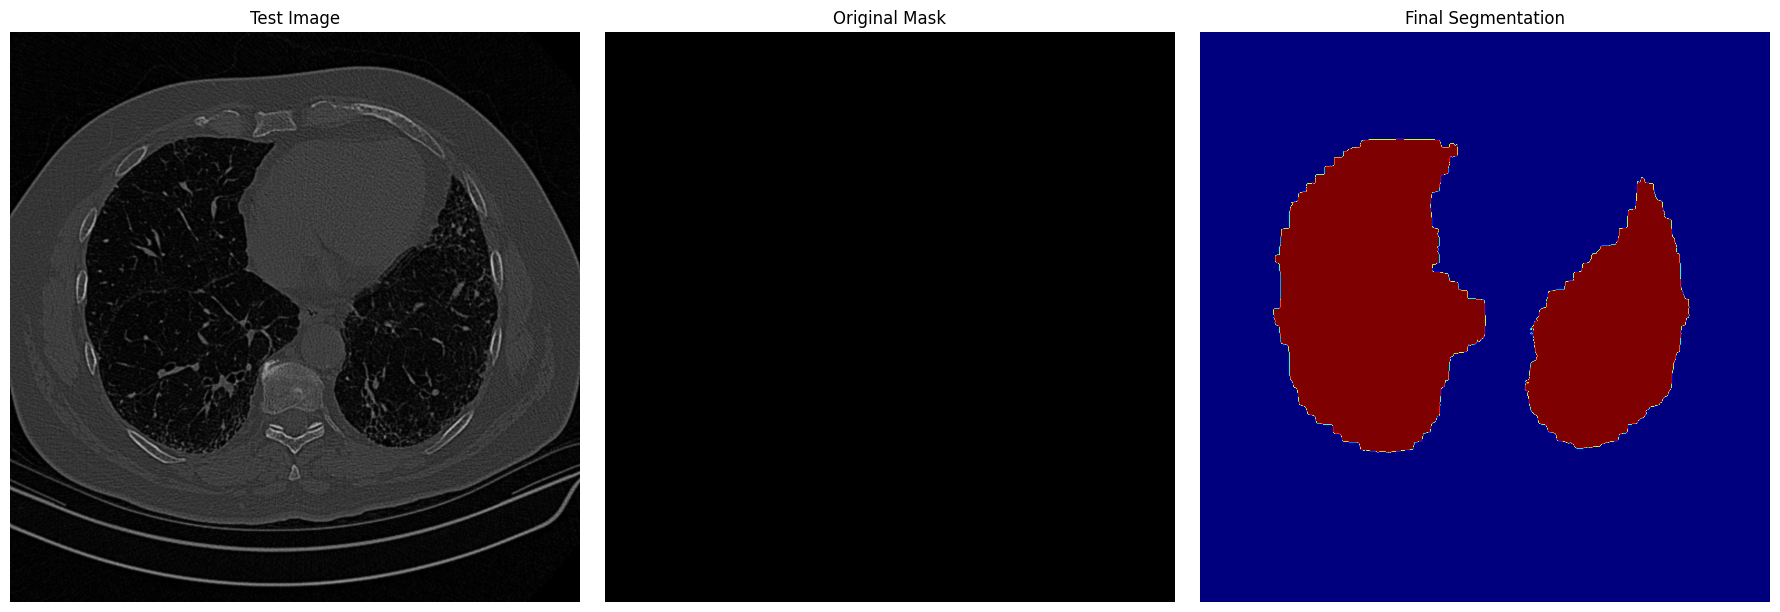

In [ ]:
import os
import cv2
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from PIL import Image

def read_image(image_path, mask_path):  # read and resize image and mask
    img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
    mask = cv2.imread(mask_path, 0)
    r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
    img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
    mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
    return img, mask

def get_points(mask, num_points):  # Sample points inside the input mask
    points = []
    coords = np.argwhere(mask > 0)
    for i in range(num_points):
        yx = np.array(coords[np.random.randint(len(coords))])
        points.append([[yx[1], yx[0]]])
    return np.array(points)

import matplotlib.pyplot as plt

# Randomly select a test image from the test_data
selected_entry = random.choice(test_data)
image_path = selected_entry['image']
mask_path = selected_entry['annotation']

# Load the selected image and mask
image, mask = read_image(image_path, mask_path)

# Generate random points for the input
num_samples = 30  # Number of points per segment to sample
input_points = get_points(mask, num_samples)

# Load the fine-tuned model
FINE_TUNED_MODEL_WEIGHTS = "fine_tuned_sam2_1000.torch"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

# Perform inference and predict masks
with torch.no_grad():
    predictor.set_image(image)
    masks, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=np.ones([input_points.shape[0], 1])
    )

# Process the predicted masks and sort by scores
np_masks = np.array(masks[:, 0])
np_scores = scores[:, 0]
sorted_masks = np_masks[np.argsort(np_scores)][::-1]

# Initialize segmentation map and occupancy mask
seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

# Combine masks to create the final segmentation map
for i in range(sorted_masks.shape[0]):
    mask = sorted_masks[i]
    if (mask * occupancy_mask).sum() / mask.sum() > 0.15:
        continue

    mask_bool = mask.astype(bool)
    mask_bool[occupancy_mask] = False  # Set overlapping areas to False in the mask
    seg_map[mask_bool] = i + 1  # Use boolean mask to index seg_map
    occupancy_mask[mask_bool] = True  # Update occupancy_mask

# Visualization: Show the original image, mask, and final segmentation side by side
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Test Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Original Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Final Segmentation')
plt.imshow(seg_map, cmap='jet')
plt.axis('off')

plt.tight_layout()
plt.show()
